
# Демонстрационная версия поиска изображений по запросу

**Задача:**

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Загрузка данных

In [1]:
# База и графики
import os
import re
from PIL import Image
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from tqdm import notebook, tqdm
import warnings
warnings.filterwarnings('ignore')

# Текст
import spacy
import nltk
# from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag


# Нейросети
import torch
import transformers
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision.models import ResNet18_Weights, resnet18
import torchvision.transforms as transforms
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression


In [2]:
# Проверка на доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")
print(torch.version.cuda)

Используемое устройство: cuda
11.8


In [3]:
BASE_PATH = './data/'
TRAIN_IMAGES = os.path.join(BASE_PATH, 'train_images')
TEST_IMAGES = os.path.join(BASE_PATH, 'test_images')
RS = 42
LETTERS = r'[^a-zA-Z\s]'
SPACES = r'([ ])\1+'

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

In [4]:
files = os.listdir(BASE_PATH)

for file in files:
    print(file)

CrowdAnnotations.tsv
ExpertAnnotations.tsv
test_images
test_images.csv
test_queries.csv
text_features.npy
train_dataset.csv
train_images


In [5]:
# загрузка информации для обучения:
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train_dataset.csv'))
    print('Информация для обучения:')
    display(train_df.head(2))
    display(train_df.info())
except Exception as e:
    print('Информация для обучения недоступна:', e)

# загрузка информации для тестирования:
try:
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test_queries.csv'), sep='|', index_col='Unnamed: 0')
    print('Информация для тестирования:')
    display(test_df.head(2))
    display(test_df.info())
except Exception as e:
    print('Информация недоступна:', e)


# оценка изображений на краудсорсинге
try:
    crowd_annotat = pd.read_csv(os.path.join(BASE_PATH, 'CrowdAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'fraction', 'conf_cnt', 'not_conf_cnt'])
    print('Оценка изображений на краудсорсинге:')
    display(crowd_annotat.head(2))
    display(crowd_annotat.info())
except Exception as e:
    print('Информация недоступна:', e)


# оценка изображений экспертами
try:
    expert_annotat = pd.read_csv(os.path.join(BASE_PATH, 'ExpertAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'exp_1', 'exp_2', 'exp_3'])
    print('Оценка изображений экспертами:')
    display(expert_annotat.head(2))
    display(expert_annotat.info())
except Exception as e:
    print('Информация недоступна:', e)

Информация для обучения:


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Информация для тестирования:


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

Оценка изображений на краудсорсинге:


,image,query_id,fraction,conf_cnt,not_conf_cnt
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   fraction      47830 non-null  float64
 3   conf_cnt      47830 non-null  int64  
 4   not_conf_cnt  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Оценка изображений экспертами:


,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

In [6]:
table = [train_df, test_df, crowd_annotat, expert_annotat]
print('Посмотрим на пропуски:')
for i in table:
    display(i.isnull().mean().sort_values())


print('Посмотрим на дубликаты:')
for i in table:
     display(i.duplicated().sum())

Посмотрим на пропуски:


image         0.0
query_id      0.0
query_text    0.0
dtype: float64

query_id      0.0
query_text    0.0
image         0.0
dtype: float64

image           0.0
query_id        0.0
fraction        0.0
conf_cnt        0.0
not_conf_cnt    0.0
dtype: float64

image       0.0
query_id    0.0
exp_1       0.0
exp_2       0.0
exp_3       0.0
dtype: float64

Посмотрим на дубликаты:


np.int64(0)

np.int64(0)

np.int64(0)

np.int64(0)

**Выводы:**

1. Пропусков нет.
2. Дубликатов полных нет.
3. Названия колонок соотвествуют стандартам.
4. Типы данных соответствуют данным.
5. Текст на английском.
6. На первый взгляд не видно критичных вопросов.

## Исследовательский анализ данных

Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. 
В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [7]:
def e_d_a(variable, name, table):
    print(f'Смотрим статистику: {name}')
    # Статистика
    display(table[variable].describe())

    # Гистограмма
    plt.figure(figsize=(15, 6))
    table[variable].hist(bins=30, range=(max(0, table[variable].min()), table[variable].max()))
    plt.title(f'Распределение {name}')
    plt.xlabel(f'{name}')
    plt.ylabel('Частота')
    plt.show()

    # Диаграмма с усами
    plt.figure(figsize=(15, 4))
    table.boxplot(column=variable, vert=False, color='green', widths=0.6)
    plt.title(f'Диаграмма межквартильного размаха для {name}')
    plt.xlabel(f'{name}')
    plt.yticks([])
    plt.grid(True, linestyle='--', alpha=0.2, linewidth=1.5)
    plt.show()


    # Описание границ
    print('\n', f'{name} находится в диапазоне от {table[variable].min():.2f}',
          f'до {table[variable].max():.2f}, посмотрим как распределяются данные, видим на графике выше:'
         )

    # Вывод 75% и 98% квантилей
    print(f'75% объектов находятся в диапазоне до {table[variable].quantile(0.75):.1f}',
          f'\n \n Всего значений отличных от 0: {len(table[table[variable]>0]):.1f}.',
          f'\n 1Q = {table[variable].quantile(0.25):.1f},',
          f'\n 3Q = {table[variable].quantile(0.75):.1f},',
          f'\n Межквартильный размах = {(table[variable].quantile(0.75) - table[variable].quantile(0.25)):.1f},',
         )

def e_d_a_categorical(variable, name, table):
    counts = table[variable].value_counts().sort_values(ascending=False)
    print(f'Смотрим статистику: {name}')
    display(table[variable].describe())
    print('Лидеров и аутсайдеров: ')
    display(counts)
    if len(counts)>20:
        print('Посмотрим на графике ТОП-10: ')
        plt.bar(counts.head(10).index, counts.head(10).values)
        plt.xlabel(name)
        plt.ylabel('Количество')
        plt.title(f'Распределение признака {name}')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(counts.min()*0.9, counts.max()*1.05)
        plt.show()
    else:
        print('Посмотрим на графике: ')
        plt.bar(counts.head(10).index, counts.head(10).values)
        plt.xlabel(name)
        plt.ylabel('Количество')
        plt.title(f'Распределение признака {name}')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(counts.min()*0.9, counts.max()*1.05)
        plt.show()

In [8]:
def type_col(df):
    numeric_columns = df.select_dtypes(include='number').columns
    text_columns = df.select_dtypes(include='object').columns
    boolean_columns = df.select_dtypes(include='bool').columns
    print(f'Числовые признаки: {numeric_columns.tolist()}\n',
          f'Логические признаки: {boolean_columns.tolist()} \n',
          f'Строковые признаки: {text_columns.tolist()} \n',)
    try:
        display(df[numeric_columns.tolist()].describe())
    except:
        print('\n')
    try:
        display(df[boolean_columns.tolist()].describe())
    except:
        print('\n')
    try:
        display(df[text_columns.tolist()].describe())
    except:
        print('\n')



for i in table:
    type_col(i)

Числовые признаки: []
 Логические признаки: [] 
 Строковые признаки: ['image', 'query_id', 'query_text'] 







,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Числовые признаки: []
 Логические признаки: [] 
 Строковые признаки: ['query_id', 'query_text', 'image'] 







,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


Числовые признаки: ['fraction', 'conf_cnt', 'not_conf_cnt']
 Логические признаки: [] 
 Строковые признаки: ['image', 'query_id'] 



,fraction,conf_cnt,not_conf_cnt
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


,image,query_id
count,47830,47830
unique,1000,1000
top,1572532018_64c030c974.jpg,249394748_2e4acfbbb5.jpg#2
freq,120,169


Числовые признаки: ['exp_1', 'exp_2', 'exp_3']
 Логические признаки: [] 
 Строковые признаки: ['image', 'query_id'] 



,exp_1,exp_2,exp_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


,image,query_id
count,5822,5822
unique,1000,977
top,3107513635_fe8a21f148.jpg,2600867924_cd502fc911.jpg#2
freq,10,34


In [9]:
train_df.head(2)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


Вывод изображений и описаний к ним:


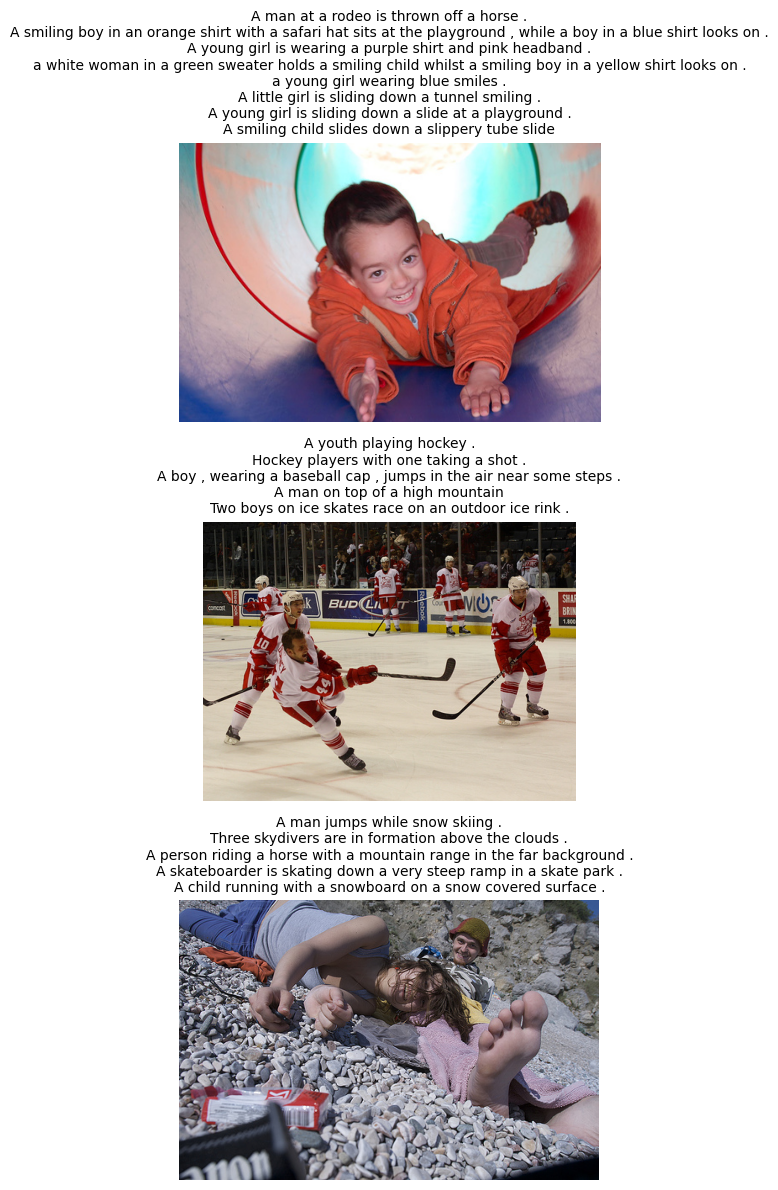

In [10]:
num_images = 3

selected_rows = train_df.sample(n=num_images, random_state=RS)

print('Вывод изображений и описаний к ним:')


fig, axes = plt.subplots(num_images, 1, figsize=(12, 4 * num_images))

for i, (index, row) in enumerate(selected_rows.iterrows()):
    image_filename = row['image']
    image_text = train_df[train_df.image == image_filename]['query_text'].tolist()
#     print(image_text)
    image_path = os.path.join(TRAIN_IMAGES, image_filename)

    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title('\n'.join(image_text), fontsize=10)
    
plt.tight_layout() 
plt.show()

Смотрим статистику: image


count                          5822
unique                         1000
top       3364151356_eecd07a23e.jpg
freq                             10
Name: image, dtype: object

Лидеров и аутсайдеров: 


image
3364151356_eecd07a23e.jpg    10
488356951_b3b77ad832.jpg     10
754852108_72f80d421f.jpg     10
3688858505_e8afd1475d.jpg    10
3107513635_fe8a21f148.jpg    10
                             ..
241346971_c100650320.jpg      2
2914206497_5e36ac6324.jpg     2
3239021459_a6b71bb400.jpg     2
3227148358_f152303584.jpg     2
2533424347_cf2f84872b.jpg     2
Name: count, Length: 1000, dtype: int64

Посмотрим на графике ТОП-10: 


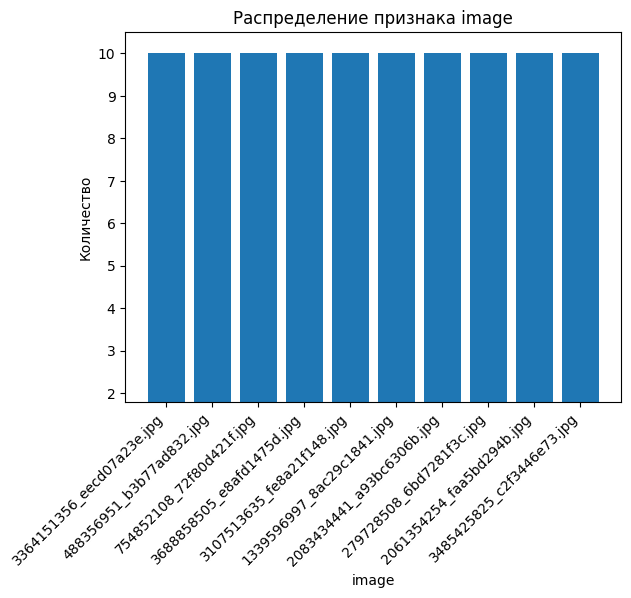

Смотрим статистику: query_id


count                            5822
unique                            977
top       2600867924_cd502fc911.jpg#2
freq                               34
Name: query_id, dtype: object

Лидеров и аутсайдеров: 


query_id
2600867924_cd502fc911.jpg#2    34
1554713437_61b64527dd.jpg#2    27
2522297487_57edf117f7.jpg#2    25
1536774449_e16b1b6382.jpg#2    25
3593392955_a4125087f6.jpg#2    22
                               ..
424779662_568f9606d0.jpg#2      1
430173345_86388d8822.jpg#2      1
2310126952_7dc86d88f6.jpg#2     1
363617160_6cb0c723be.jpg#2      1
2292406847_f366350600.jpg#2     1
Name: count, Length: 977, dtype: int64

Посмотрим на графике ТОП-10: 


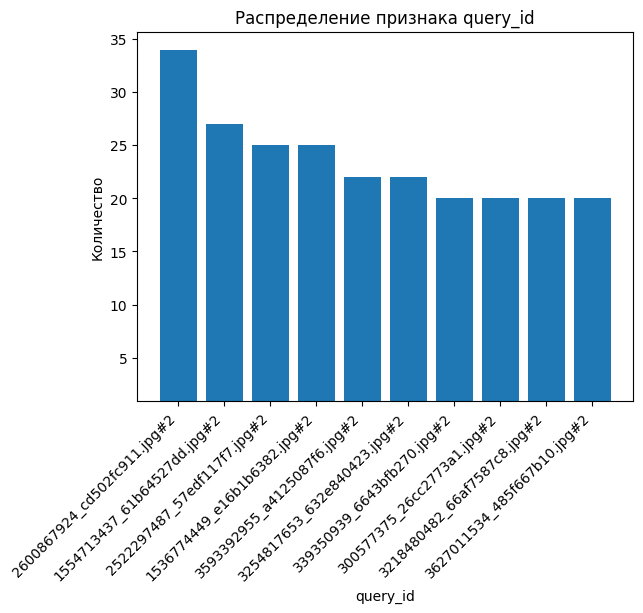

Смотрим статистику: query_text


count                                                  5822
unique                                                  977
top       Two dogs , one brown and white and one black a...
freq                                                     34
Name: query_text, dtype: object

Лидеров и аутсайдеров: 


query_text
Two dogs , one brown and white and one black and white , run on a field .                                   34
A grey dog walks on top of a fallen tree in the woods .                                                     27
a white woman in a green sweater holds a smiling child whilst a smiling boy in a yellow shirt looks on .    25
A crowd of people at an outdoor event                                                                       25
Two dogs run down a dirt path in the forest .                                                               22
                                                                                                            ..
Three women dressed in green celebrating St Patricks Day .                                                   1
A brown dog with a purple Frisbee in its mouth .                                                             1
A sled dog team running from the perspective of the rider .                                          

Посмотрим на графике ТОП-10: 


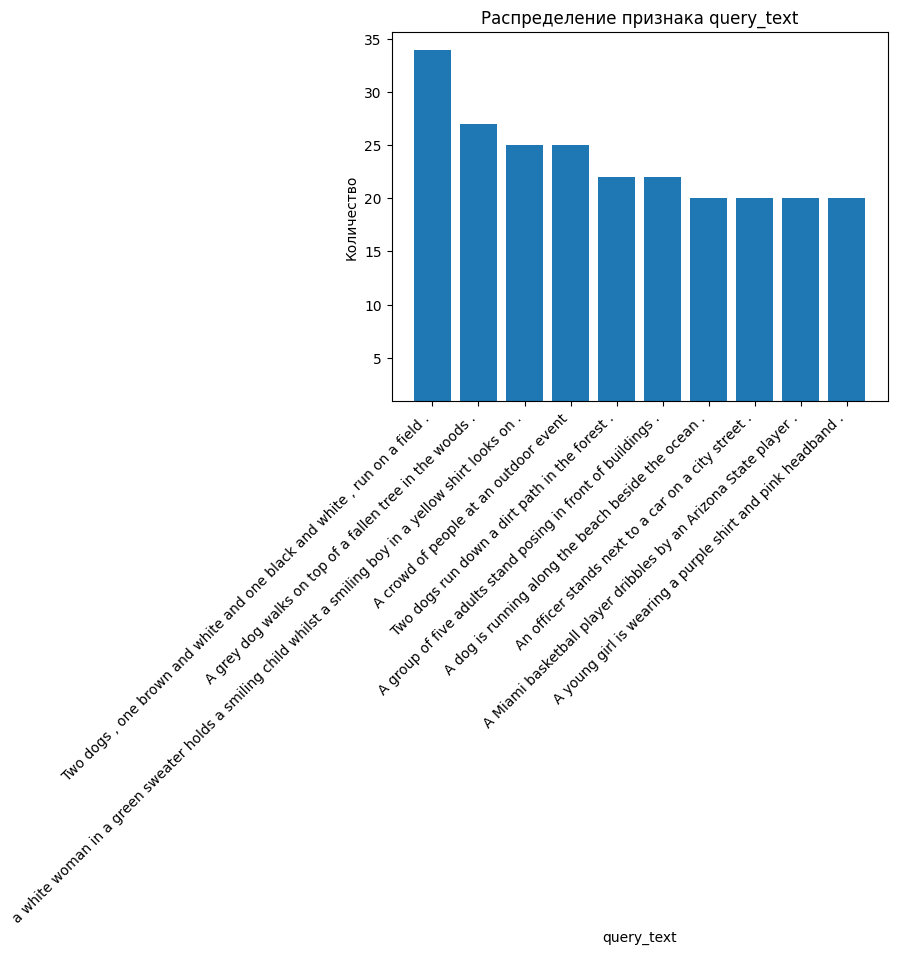

Смотрим статистику: query_id


count                             500
unique                            500
top       1177994172_10d143cb8d.jpg#0
freq                                1
Name: query_id, dtype: object

Лидеров и аутсайдеров: 


query_id
1177994172_10d143cb8d.jpg#0    1
1319634306_816f21677f.jpg#0    1
1177994172_10d143cb8d.jpg#2    1
1177994172_10d143cb8d.jpg#3    1
1177994172_10d143cb8d.jpg#4    1
                              ..
989851184_9ef368e520.jpg#2     1
989851184_9ef368e520.jpg#3     1
862156271_3eacea90a8.jpg#1     1
862156271_3eacea90a8.jpg#0     1
989851184_9ef368e520.jpg#4     1
Name: count, Length: 500, dtype: int64

Посмотрим на графике ТОП-10: 


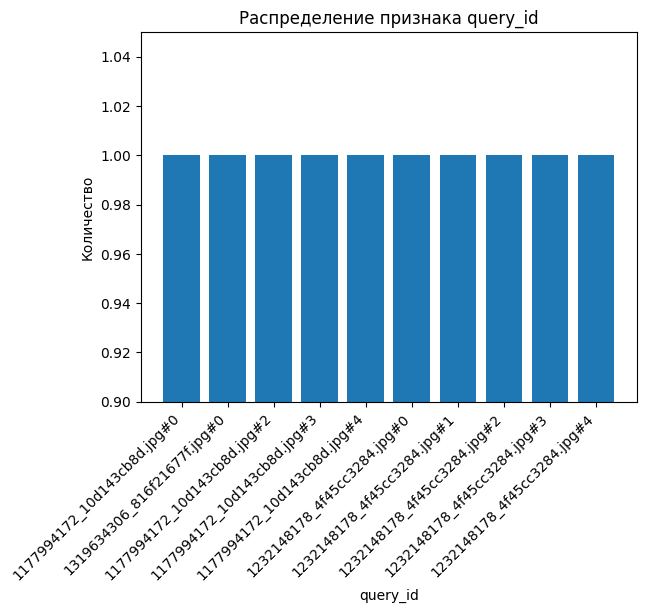

Смотрим статистику: query_text


count                                                   500
unique                                                  500
top       Two blonde boys , one in a camouflage shirt an...
freq                                                      1
Name: query_text, dtype: object

Лидеров и аутсайдеров: 


query_text
Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .    1
A brown dog is sitting in some long grass .                                                       1
Two boys spraying each other with water                                                           1
Two children wearing jeans squirt water at each other .                                           1
Two young boys are squirting water at each other .                                                1
                                                                                                 ..
A black dog holding a weight in its mouth stands next to a person .                               1
A black dog holds a small white dumbbell in its mouth .                                           1
two girls walking in the street                                                                   1
Girls with orange hair standing on the street with some kind of bottle in their hand .   

Посмотрим на графике ТОП-10: 


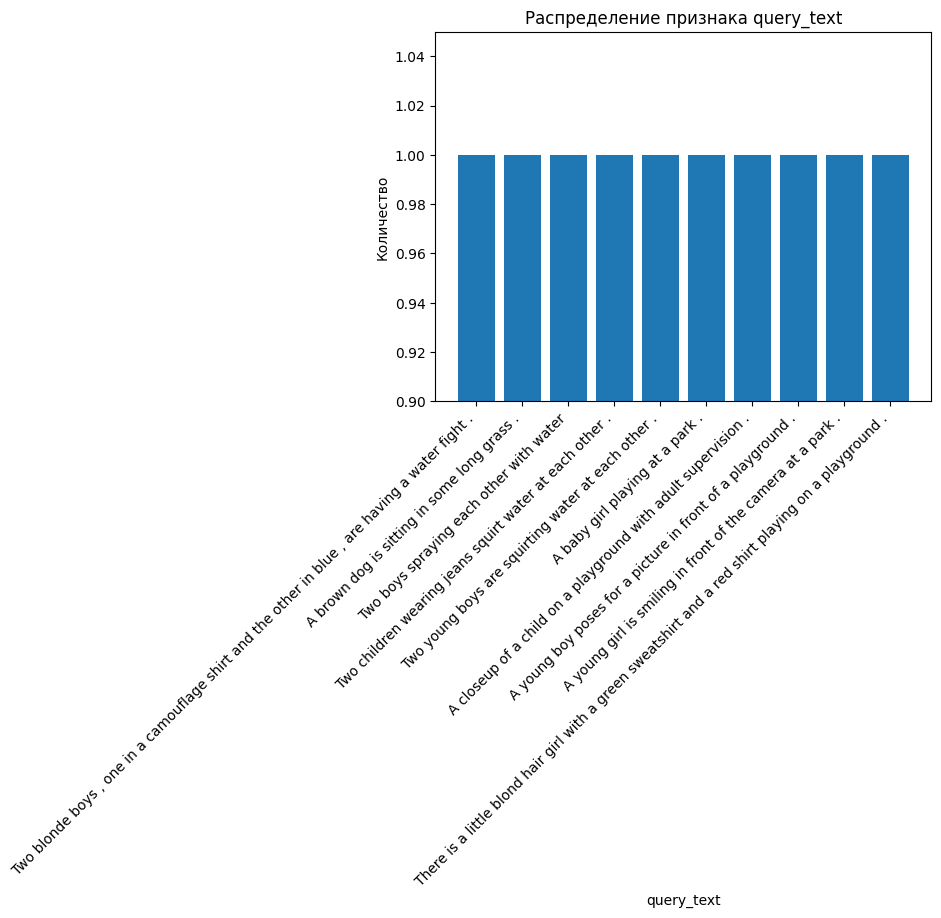

Смотрим статистику: image


count                           500
unique                          100
top       1177994172_10d143cb8d.jpg
freq                              5
Name: image, dtype: object

Лидеров и аутсайдеров: 


image
1177994172_10d143cb8d.jpg    5
2107838729_a527e434bd.jpg    5
123997871_6a9ca987b1.jpg     5
1319634306_816f21677f.jpg    5
1429546659_44cb09cbe2.jpg    5
                            ..
957682378_46c3b07bcd.jpg     5
973827791_467d83986e.jpg     5
989754491_7e53fb4586.jpg     5
3520936130_9e90872560.jpg    5
989851184_9ef368e520.jpg     5
Name: count, Length: 100, dtype: int64

Посмотрим на графике ТОП-10: 


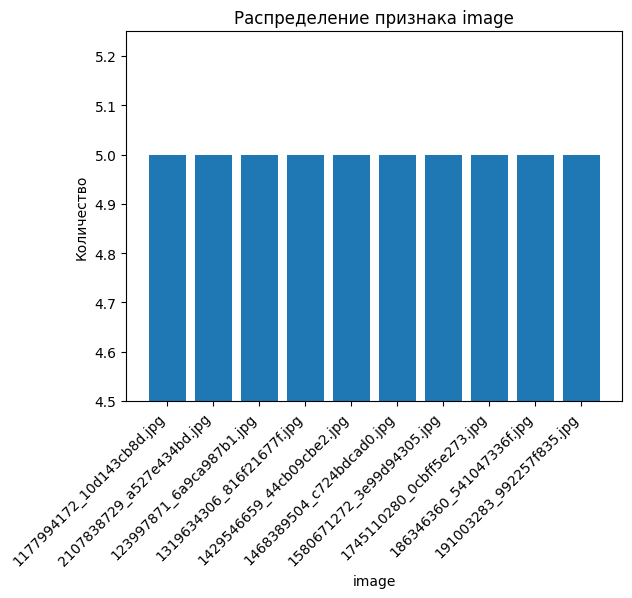

Смотрим статистику: image


count                         47830
unique                         1000
top       1572532018_64c030c974.jpg
freq                            120
Name: image, dtype: object

Лидеров и аутсайдеров: 


image
1572532018_64c030c974.jpg    120
3250695024_93e8ab7305.jpg    110
3224227640_31865b3651.jpg    100
191003285_edd8d0cf58.jpg     100
324208502_674488bcea.jpg     100
                            ... 
2295750198_6d152d7ceb.jpg     10
3578841731_f775cab089.jpg     10
363617160_6cb0c723be.jpg      10
3449114979_6cdc3e8da8.jpg     10
3567061016_62768dcce1.jpg     10
Name: count, Length: 1000, dtype: int64

Посмотрим на графике ТОП-10: 


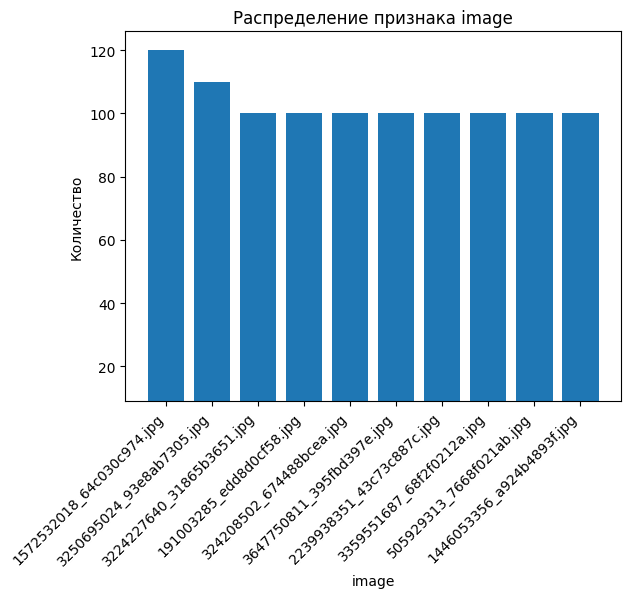

Смотрим статистику: query_id


count                          47830
unique                          1000
top       249394748_2e4acfbbb5.jpg#2
freq                             169
Name: query_id, dtype: object

Лидеров и аутсайдеров: 


query_id
249394748_2e4acfbbb5.jpg#2     169
820169182_f5e78d7d19.jpg#2     150
500446858_125702b296.jpg#2     149
2869491449_1041485a6b.jpg#2    143
327415627_6313d32a64.jpg#2     139
                              ... 
3191135894_2b4bdabb6d.jpg#2      9
3584561689_b6eb24dd70.jpg#2      7
3042380610_c5ea61eef8.jpg#2      7
1547883892_e29b3db42e.jpg#2      7
3197981073_3156963446.jpg#2      6
Name: count, Length: 1000, dtype: int64

Посмотрим на графике ТОП-10: 


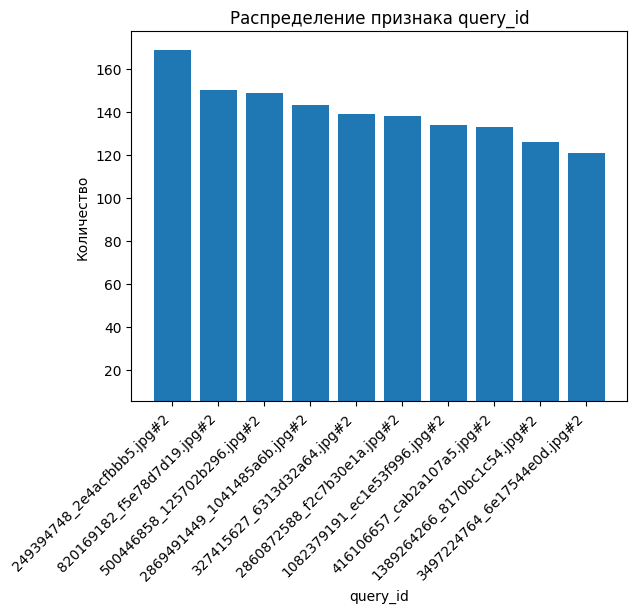

Смотрим статистику: fraction


count    47830.000000
mean         0.068786
std          0.207532
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: fraction, dtype: float64

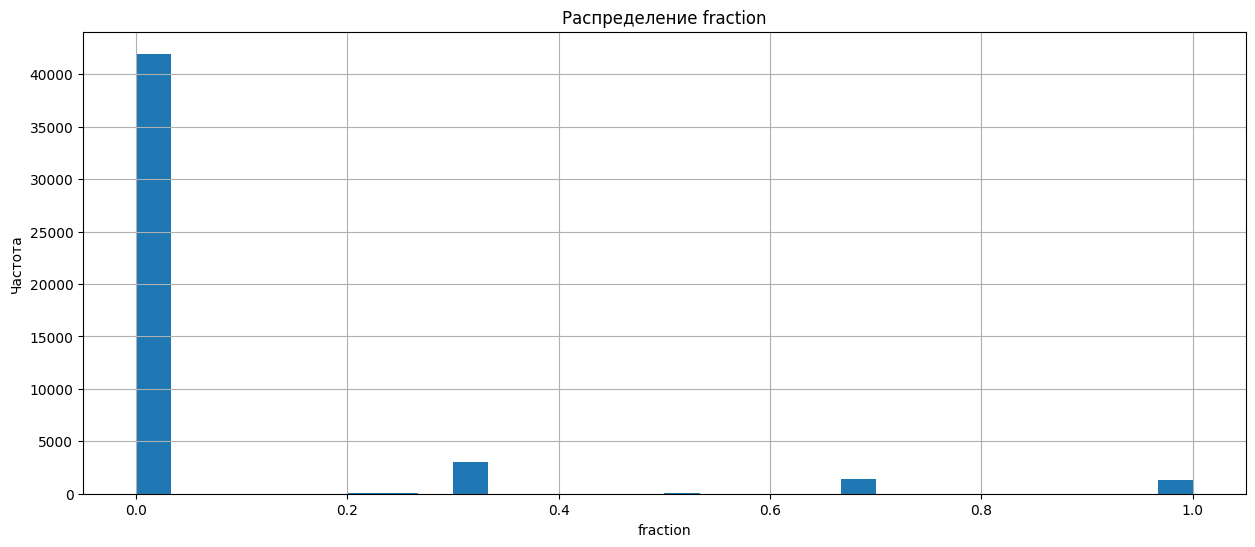

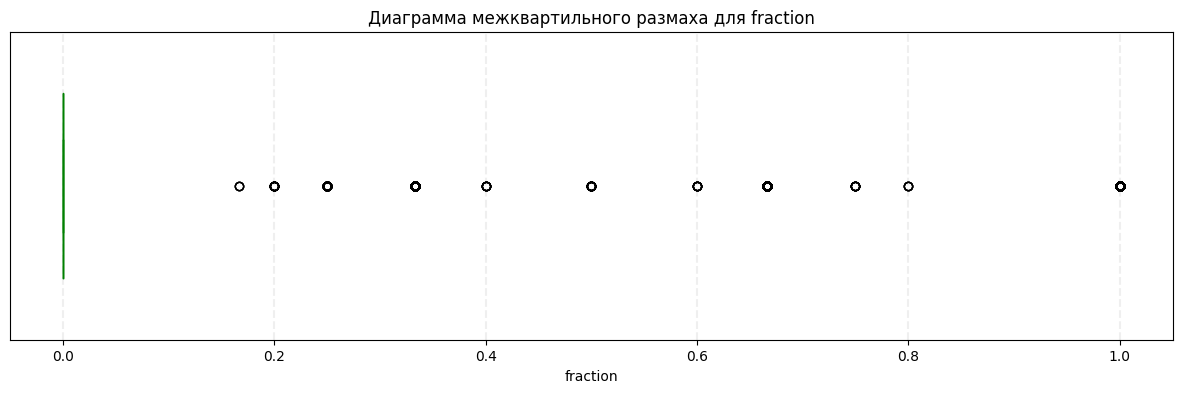


 fraction находится в диапазоне от 0.00 до 1.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 0.0 
 
 Всего значений отличных от 0: 5860.0. 
 1Q = 0.0, 
 3Q = 0.0, 
 Межквартильный размах = 0.0,
Смотрим статистику: conf_cnt


count    47830.000000
mean         0.208488
std          0.628898
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: conf_cnt, dtype: float64

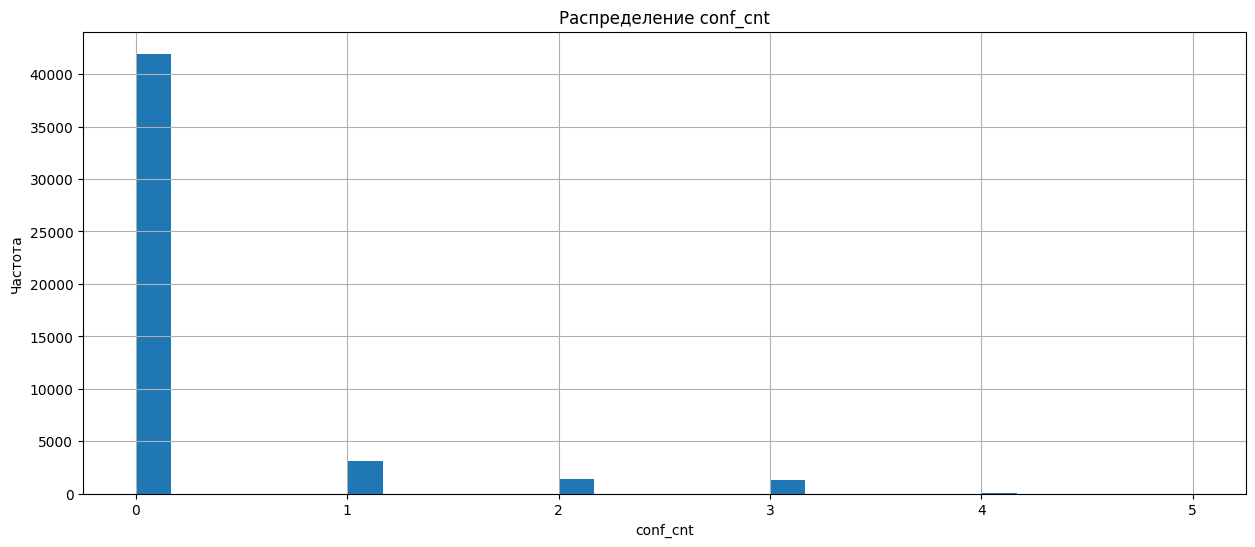

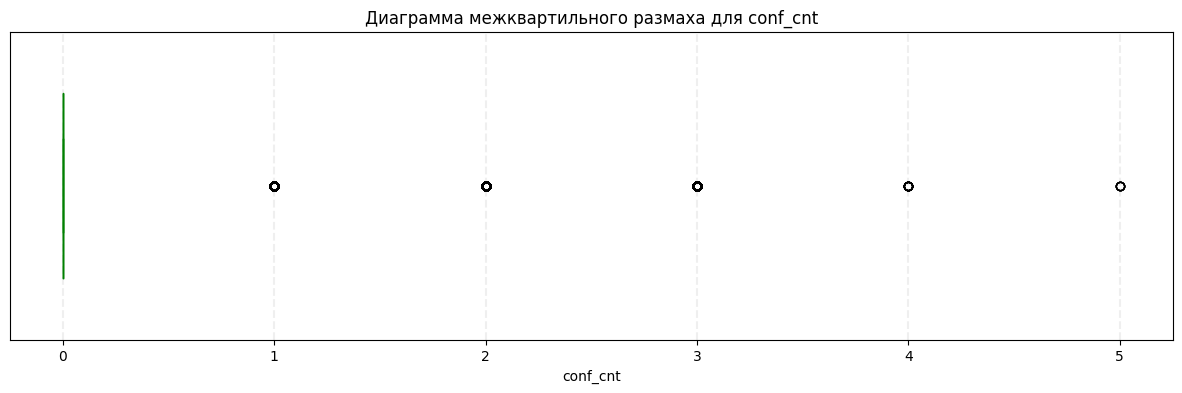


 conf_cnt находится в диапазоне от 0.00 до 5.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 0.0 
 
 Всего значений отличных от 0: 5860.0. 
 1Q = 0.0, 
 3Q = 0.0, 
 Межквартильный размах = 0.0,
Смотрим статистику: not_conf_cnt


count    47830.000000
mean         2.820155
std          0.656676
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: not_conf_cnt, dtype: float64

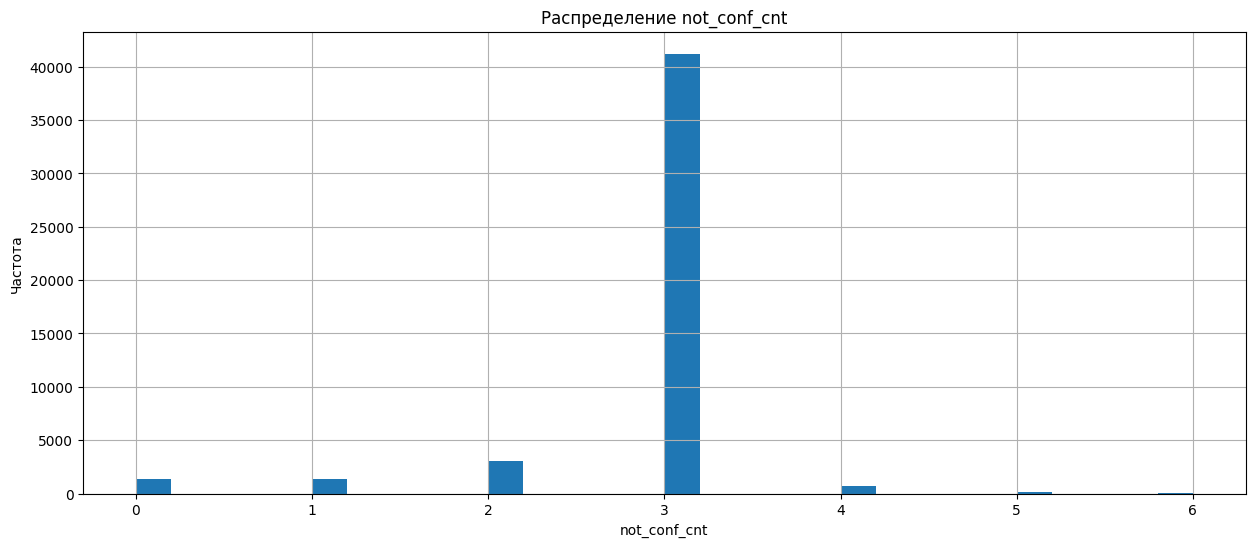

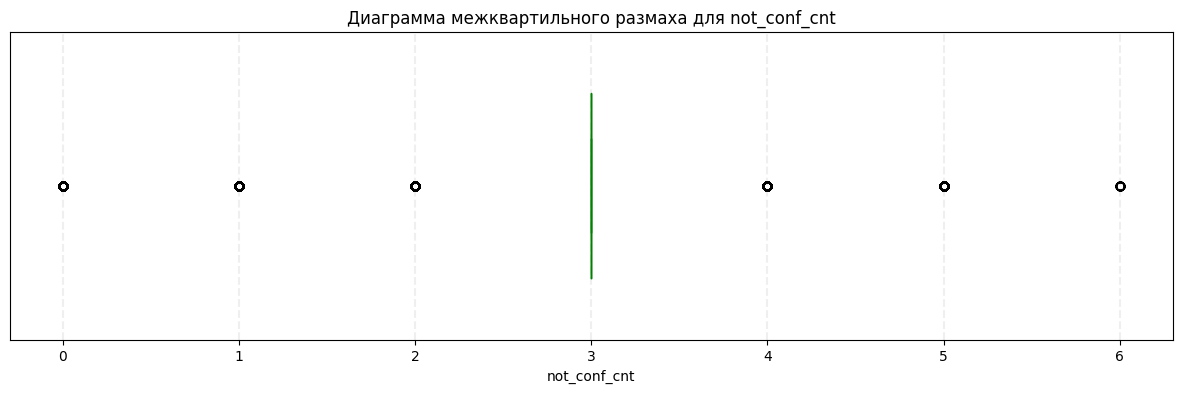


 not_conf_cnt находится в диапазоне от 0.00 до 6.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 3.0 
 
 Всего значений отличных от 0: 46507.0. 
 1Q = 3.0, 
 3Q = 3.0, 
 Межквартильный размах = 0.0,
Смотрим статистику: image


count                          5822
unique                         1000
top       3107513635_fe8a21f148.jpg
freq                             10
Name: image, dtype: object

Лидеров и аутсайдеров: 


image
3107513635_fe8a21f148.jpg    10
3364151356_eecd07a23e.jpg    10
279728508_6bd7281f3c.jpg     10
754852108_72f80d421f.jpg     10
488356951_b3b77ad832.jpg     10
                             ..
3227148358_f152303584.jpg     2
2914206497_5e36ac6324.jpg     2
2533424347_cf2f84872b.jpg     2
3591462960_86045906bd.jpg     2
241346971_c100650320.jpg      2
Name: count, Length: 1000, dtype: int64

Посмотрим на графике ТОП-10: 


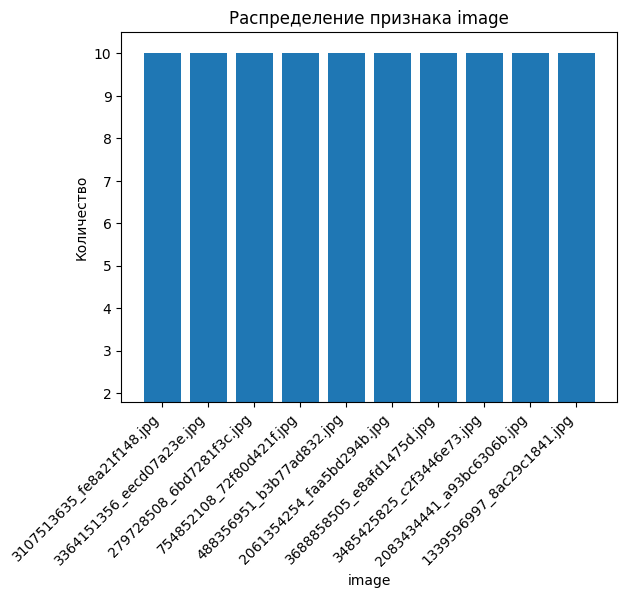

Смотрим статистику: query_id


count                            5822
unique                            977
top       2600867924_cd502fc911.jpg#2
freq                               34
Name: query_id, dtype: object

Лидеров и аутсайдеров: 


query_id
2600867924_cd502fc911.jpg#2    34
1554713437_61b64527dd.jpg#2    27
2522297487_57edf117f7.jpg#2    25
1536774449_e16b1b6382.jpg#2    25
3593392955_a4125087f6.jpg#2    22
                               ..
424779662_568f9606d0.jpg#2      1
430173345_86388d8822.jpg#2      1
2310126952_7dc86d88f6.jpg#2     1
363617160_6cb0c723be.jpg#2      1
2292406847_f366350600.jpg#2     1
Name: count, Length: 977, dtype: int64

Посмотрим на графике ТОП-10: 


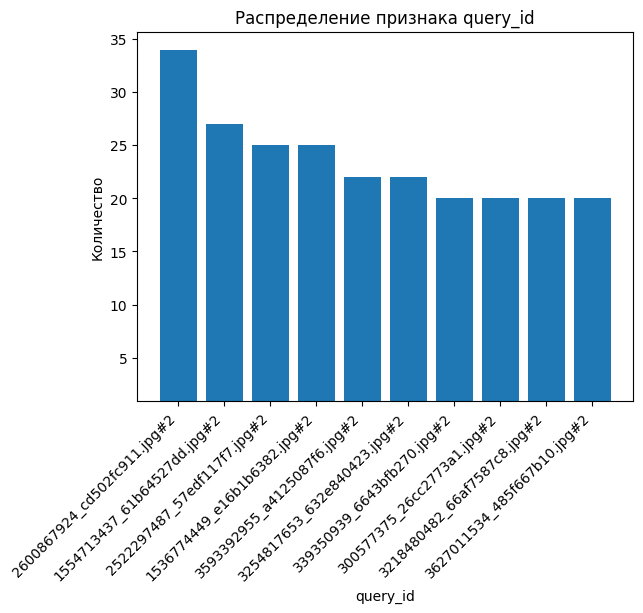

Смотрим статистику: exp_1


count    5822.000000
mean        1.436620
std         0.787084
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: exp_1, dtype: float64

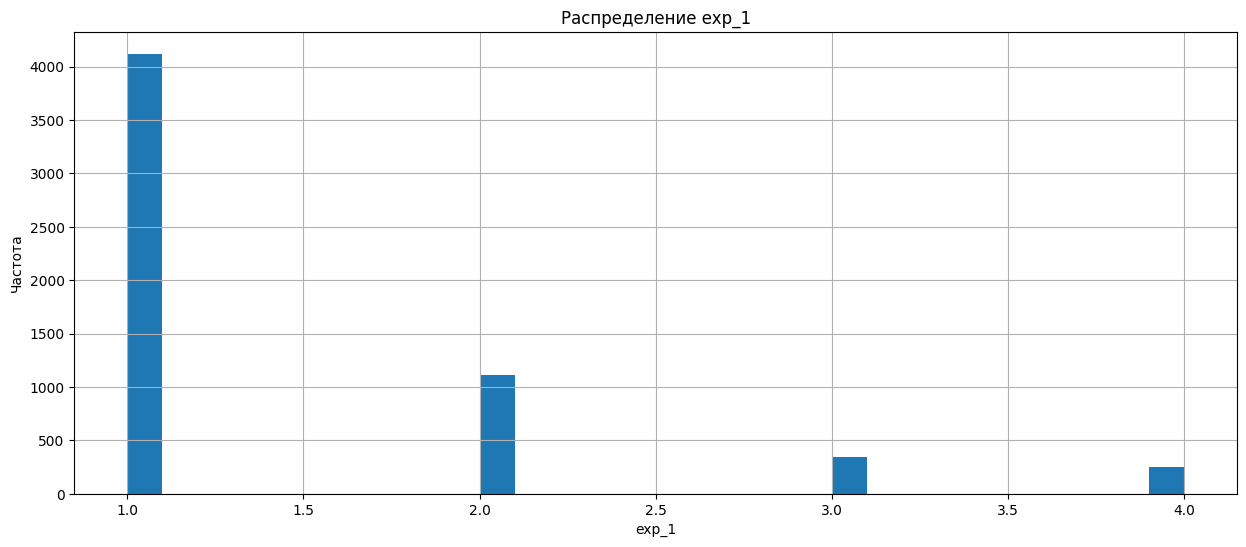

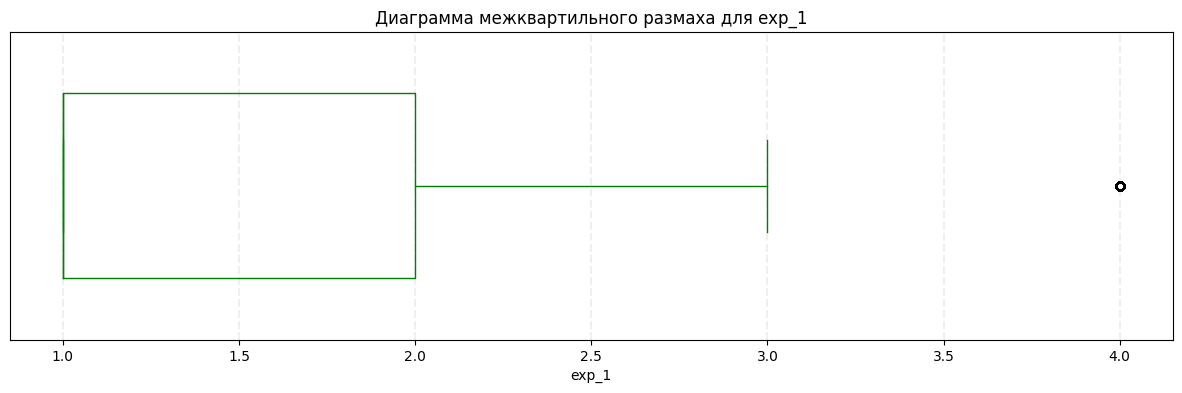


 exp_1 находится в диапазоне от 1.00 до 4.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 2.0 
 
 Всего значений отличных от 0: 5822.0. 
 1Q = 1.0, 
 3Q = 2.0, 
 Межквартильный размах = 1.0,
Смотрим статистику: exp_2


count    5822.000000
mean        1.624356
std         0.856222
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: exp_2, dtype: float64

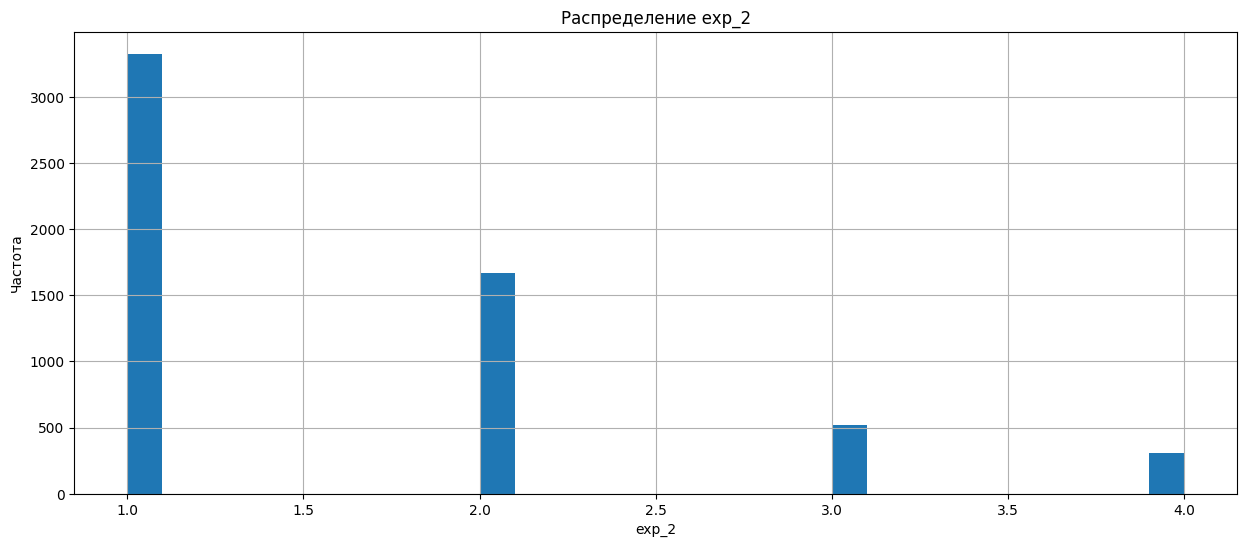

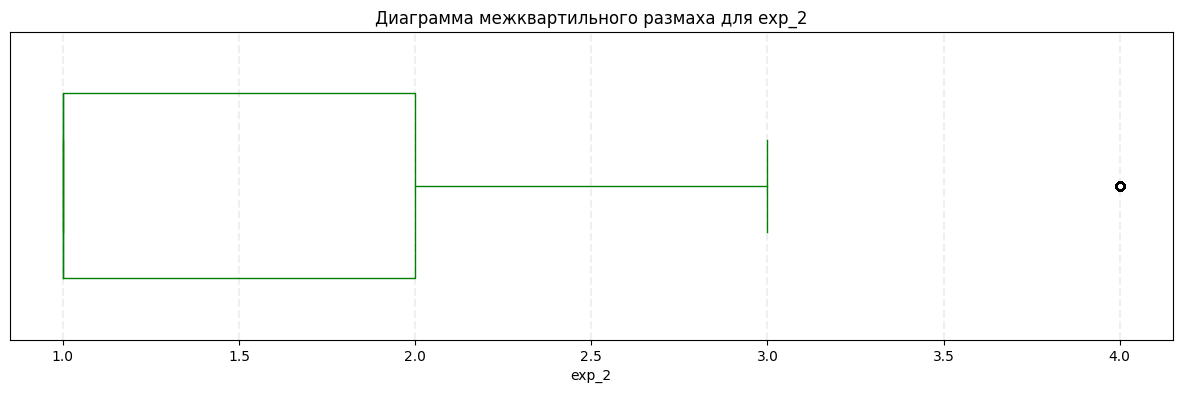


 exp_2 находится в диапазоне от 1.00 до 4.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 2.0 
 
 Всего значений отличных от 0: 5822.0. 
 1Q = 1.0, 
 3Q = 2.0, 
 Межквартильный размах = 1.0,
Смотрим статистику: exp_3


count    5822.000000
mean        1.881999
std         0.904087
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: exp_3, dtype: float64

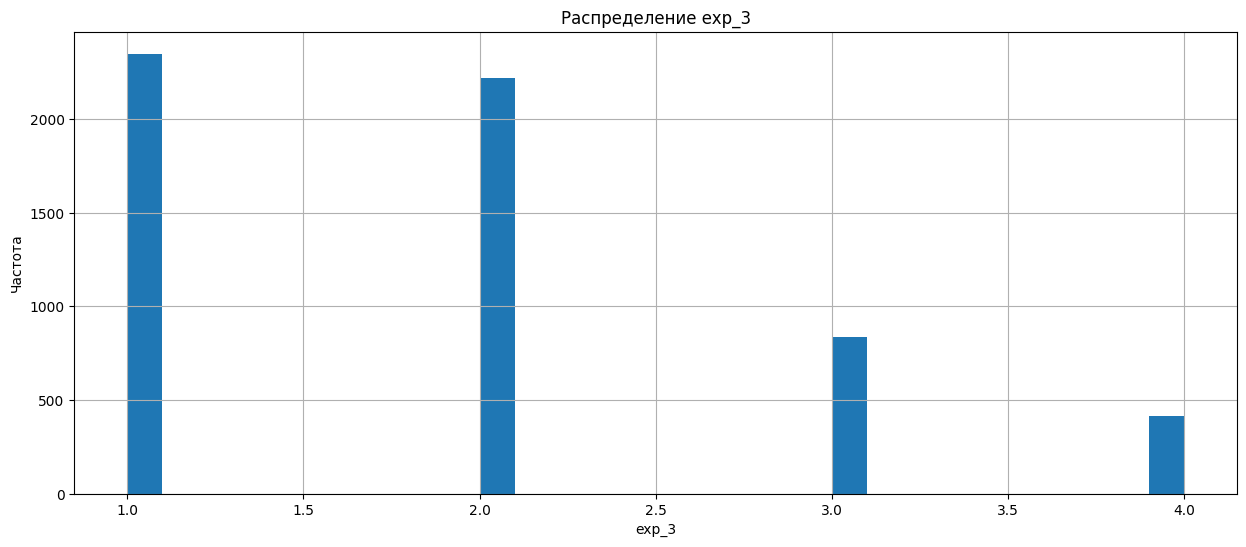

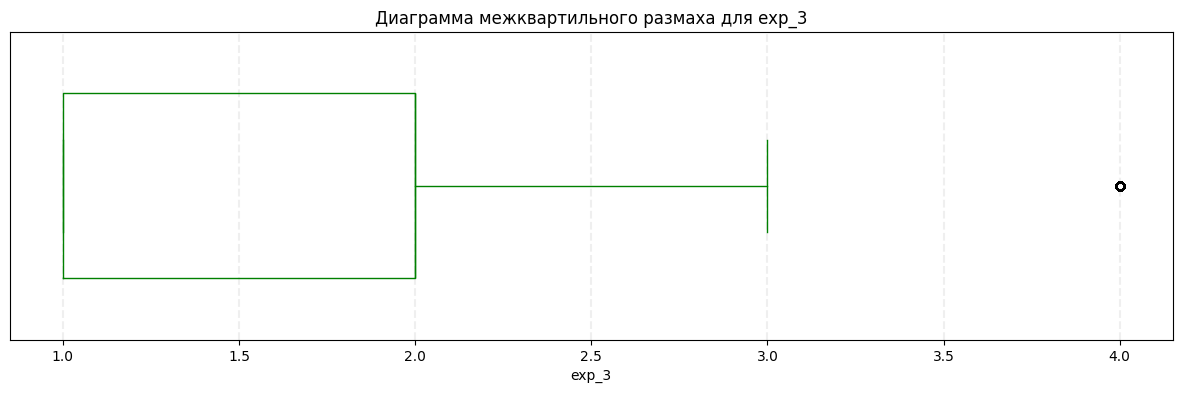


 exp_3 находится в диапазоне от 1.00 до 4.00, посмотрим как распределяются данные, видим на графике выше:
75% объектов находятся в диапазоне до 2.0 
 
 Всего значений отличных от 0: 5822.0. 
 1Q = 1.0, 
 3Q = 2.0, 
 Межквартильный размах = 1.0,


In [11]:
for i in table:
    numeric_columns = i.select_dtypes(include='number').columns
    text_columns = i.select_dtypes(include='object').columns
    for j in i.columns:
        if j in numeric_columns:
            e_d_a(j, j, i)
        if j in text_columns:
            e_d_a_categorical(j, j, i)

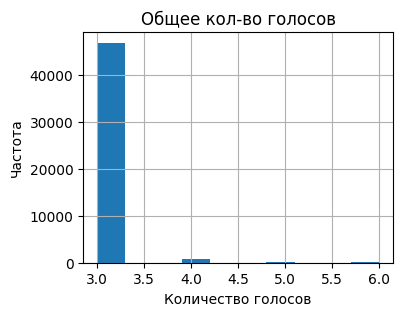

In [12]:
crowd_annotat['total_votes'] = crowd_annotat['conf_cnt'] + crowd_annotat['not_conf_cnt']

plt.figure(figsize=(4, 3))
crowd_annotat['total_votes'].hist()
plt.title("Общее кол-во голосов")
plt.xlabel("Количество голосов")
plt.ylabel("Частота")
plt.show()

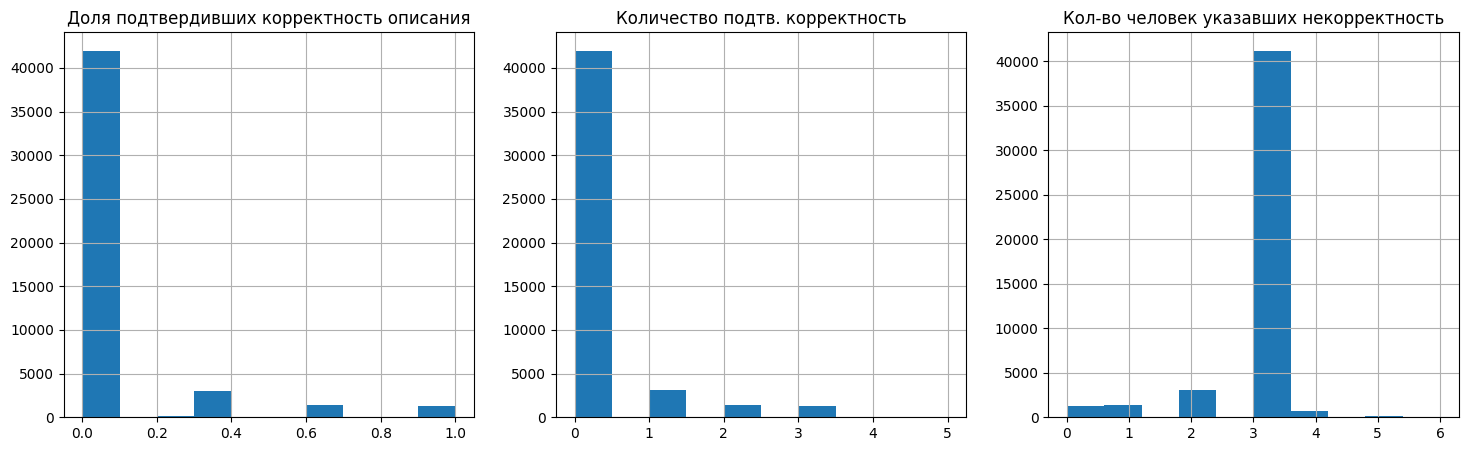

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

crowd_annotat['fraction'].hist(ax=axes[0])
axes[0].set_title("Доля подтвердивших корректность описания")

crowd_annotat['conf_cnt'].hist(ax=axes[1])
axes[1].set_title("Количество подтв. корректность")

crowd_annotat['not_conf_cnt'].hist(ax=axes[2])
axes[2].set_title("Кол-во человек указавших некорректность")

plt.show()

**Выводы:**
1. Отзывы экспертов распределяются достаточно равномерно, почти 70% находятся в диапазоне от 1 до 2, по 4х бальной шкале.
2. По оценкам краудсорсинга ситуация обстоит по другому: больше оценок, но при этом больше разброс.
3. Боле 40 тысяч изображений содержит оценку 3 голосов. Большее количество голосов - уже исключение.
4. Как видим большое количество некорректно идентифицированных аннотаций к изображениям - оправдано. Некорректных аннотаций достаточно много. 

In [14]:
def mean_exp(x):
    return np.mean([x['exp_1'], x['exp_2'], x['exp_3']])

expert_annotat['mean_exp'] = expert_annotat.apply(mean_exp, axis=1)

train = train_df.copy()
train_df = train_df.merge(expert_annotat, on=['image', 'query_id'], how='outer')[['image', 'mean_exp', 'query_text', 'query_id']]
# перевод экспертные оценки из шкалы 1-4 в шкалу 0-1.
scaler = MinMaxScaler()
train_df['mean_exp'] = scaler.fit_transform(train_df[['mean_exp']])

In [15]:
train_df.sample(3)

,image,mean_exp,query_text,query_id
4274,3484832904_08619300d9.jpg,0.333333,A baseman tries to catch a ball while a runner...,3514179514_cbc3371b92.jpg#2
2779,3025549604_38b86198f5.jpg,0.000000,A homeless man stands with a sign next to oran...,2612488996_9450de0e54.jpg#2
5173,424779662_568f9606d0.jpg,0.111111,A woman dressed in black standing at a green c...,506367606_7cca2bba9b.jpg#2


**Важно:**

Опираться будем на объединенный набор данных оценками экспертов и краудсорсинговые оценки, что бы оставить как можно больше данных, пусть и не совсем чистых.

## Проверка данных

Например, если в некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

У нас нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [16]:

def lemma_clear(text):
    lemm = nlp(text)
    lemm = " ".join([token.lemma_ for token in lemm])


    return " ".join(lemm.split())

Пишем функцию для лемматизации входного текста, что позволяет преобразовать слова в их базовые формы. Это упрощает анализ текста, так как разные формы одного и того же слова будут представлены одинаково. Кроме того, функция очищает результат от лишних пробелов, обеспечивая аккуратный вывод. Что должно повысить точность определения таких изображений.

Собираем список таких слов, для анализа:

In [17]:
nlp = spacy.load("en_core_web_sm")


In [18]:
child_dict = ['child', 'baby', 'boy', 'girl', 'teenager', 'schoolboy', 'youth', 'newborn']


def filter_child_words(text):
    doc = nlp(text)
    filtered_words = []
    
    for token in doc:
        if token.pos_ == 'NOUN' and (token.lemma_ in child_dict):
            filtered_words.append(token.text.lower())
    
    return filtered_words


corpus = train_df['query_text'].apply(filter_child_words)

Применяем фильтр, что бы убрать изображения нарушающие законодательство.

In [19]:
def is_ban_word(text):
    if isinstance(text, list):  
        text = ' '.join(text) 
    for s in child_dict:
        if text.find(s) > -1:
            return False
    return True

In [20]:
train_df['lem_query_text'] = corpus
train_df['is_in_law'] = corpus.apply(is_ban_word)

In [21]:
def spl(text):
    return text[:text.find('#')]

Список изображений нарушающих закон.

In [22]:
child_images = list(train_df[train_df['is_in_law']==False]['query_id'].apply(spl).unique())

In [23]:
print('Смотрим количество изображений нарушающих закон и общую длину df:')
print(len(child_images))
print(len(train_df))

Смотрим количество изображений нарушающих закон и общую длину df:
270
5822


In [24]:
def is_not_forb(text):
    if text in child_images:
        return False
    else:
        return True

train_df_clear = train_df[train_df['is_in_law']]
train_df = train_df_clear[train_df_clear['image'].apply(is_not_forb)]

In [25]:
print('Итого после фильтра осталось записей: ', len(train_df))

Итого после фильтра осталось записей:  3322


**Выводы:**
Были обработаны описания к фотографиям, если встречались слова которые указывали на нарушение закона, такие изображения были исключены из выборки.

## Векторизация текстов

In [26]:
tqdm.pandas()

# инициализация токенизатор, конфигурацию и модель BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model_emb_txt = transformers.BertModel.from_pretrained('bert-base-uncased', config=config).to(device)


tokenized = train_df['query_text'].progress_apply(lambda x:
                                           tokenizer.encode(x, max_length=512,
                                                            truncation=True, add_special_tokens=True))

padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)

attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

100%|████████████████████████████████████████████████████████████████████████████| 3322/3322 [00:02<00:00, 1409.87it/s]


In [27]:
len(train_df['query_text'])

3322

In [28]:
padded.shape[0]

3322

In [29]:
batch_size = 100
embeddings = []

for i in tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.Tensor(attention_mask[batch_size * i:batch_size * (i + 1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model_emb_txt(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

# Обработка остатка
if padded.shape[0] % batch_size != 0:
    last_batch = torch.LongTensor(padded[(padded.shape[0] // batch_size) * batch_size:]).to(device)
    attention_mask_last_batch = torch.Tensor(attention_mask[(padded.shape[0] // batch_size) * batch_size:]).to(device)

    with torch.no_grad():
        last_batch_embeddings = model_emb_txt(last_batch, attention_mask=attention_mask_last_batch)

    embeddings.append(last_batch_embeddings[0][:, 0, :].cpu().numpy())

text_features = np.concatenate(embeddings)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 13.30it/s]


In [30]:
len(text_features)

3322

In [31]:
# дополнение датасета эмбедингами
train_df['text_embeddings'] = text_features.tolist()

## Векторизация изображений

Перейдём к векторизации изображений.

In [32]:
weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights).to(device)

for param in resnet.parameters():
    param.requires_grad_(False)

# оставим только свёрточные слои
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules).to(device)

resnet.eval()



preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_images_list = train_df['image'].unique()

In [33]:
vektors = []


for image_name in tqdm(train_images_list):
    image = Image.open(os.path.join(TRAIN_IMAGES, image_name)).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0).to(device) 

    vektor = resnet(image).cpu().flatten().numpy()
    vektors.append(vektor)


100%|████████████████████████████████████████████████████████████████████████████████| 724/724 [00:14<00:00, 48.94it/s]


In [34]:
images_vektors = np.array(vektors)
data = pd.DataFrame({'image': train_images_list, 'image_vector': images_vektors.tolist()})

train_df = train_df.merge(data, on='image', how='left')

## Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.

In [35]:
train_df.head(2)

,image,mean_exp,query_text,query_id,lem_query_text,is_in_law,text_embeddings,image_vector
0,1056338697_4f7d7ce270.jpg,0.111111,A man sleeps under a blanket on a city street .,3181701312_70a379ab6e.jpg#2,[],True,"[0.22594551742076874, -0.14776965975761414, -0...","[0.6939702033996582, 3.030940055847168, 2.9169..."
1,1056338697_4f7d7ce270.jpg,0.222222,A woman plays with long red ribbons in an empt...,3207358897_bfa61fa3c6.jpg#2,[],True,"[0.3637191355228424, 0.16300800442695618, -0.4...","[0.6939702033996582, 3.030940055847168, 2.9169..."


In [36]:
for i in range(2):
    print(f'''
    Размерность {i+1}-й пары:
    text_embeddings: {len(train_df.iloc[i][-2])}
    image_vector: {len(train_df.iloc[i][-1])}
    ''')


    Размерность 1-й пары:
    text_embeddings: 768
    image_vector: 512
    

    Размерность 2-й пары:
    text_embeddings: 768
    image_vector: 512
    


In [37]:
train_df['concatenated_vector'] = train_df.apply(lambda row: np.concatenate([row['text_embeddings'], row['image_vector']], axis=None), axis=1)
concatenated_vector = train_df.iloc[0, -1]

if isinstance(concatenated_vector, (np.ndarray, list)):
    print(f'Размерность объединенного вектора: {len(concatenated_vector)}')
else:
    print('Объединенный вектор не является массивом или списком.')

Размерность объединенного вектора: 1280


In [38]:
train_df.head(2)

,image,mean_exp,query_text,query_id,lem_query_text,is_in_law,text_embeddings,image_vector,concatenated_vector
0,1056338697_4f7d7ce270.jpg,0.111111,A man sleeps under a blanket on a city street .,3181701312_70a379ab6e.jpg#2,[],True,"[0.22594551742076874, -0.14776965975761414, -0...","[0.6939702033996582, 3.030940055847168, 2.9169...","[0.22594551742076874, -0.14776965975761414, -0..."
1,1056338697_4f7d7ce270.jpg,0.222222,A woman plays with long red ribbons in an empt...,3207358897_bfa61fa3c6.jpg#2,[],True,"[0.3637191355228424, 0.16300800442695618, -0.4...","[0.6939702033996582, 3.030940055847168, 2.9169...","[0.3637191355228424, 0.16300800442695618, -0.4..."


## Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.


Для оценки качества буду использовать RMSE потому, что ее значения имеют ту же размерность, что и исходные данные, а это легче интерпретировать и более понятно.

In [39]:
def rmse_score(values, predict):
    return sqrt(mean_squared_error(values, predict))

rmse_scorer = make_scorer(rmse_score)

# функция для вывода результатов
def output_results(trial):
    print('Результаты подборы параметров:')
    print('  RMSE:', round(trial.value, 3))
    print('  Params: ')
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


In [40]:
final_df = train_df.copy()
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RS)
train_indices, test_indices = next(gss.split(X=final_df.drop(columns=['mean_exp']), y=final_df['mean_exp'],
                                             groups=final_df['image']))
train_df, valid_df = final_df.loc[train_indices], final_df.loc[test_indices]

X_train = train_df['concatenated_vector'].apply(pd.Series).values
y_train = train_df['mean_exp']

X_valid = valid_df['concatenated_vector'].apply(pd.Series).values
y_valid = valid_df['mean_exp']

### Baseline model

константная модель, которая предсказывает среднее значение

In [41]:
dummy_model = DummyRegressor(strategy="mean")

dummy_model.fit(X_train, y_train)

dummy_predictions = dummy_model.predict(X_valid)

rmse = rmse_score(y_valid, dummy_predictions)
print(f'RMSE(Dummy Model): {rmse}')

RMSE(Dummy Model): 0.2890321964170794


### LinearRegression

**Регрессия** со скалированием

In [42]:
final_df_sc = train_df.copy()
final_df_sc = final_df_sc.reset_index(drop=True)

scaler = MinMaxScaler()
final_df_sc['mean_exp'] = scaler.fit_transform(final_df_sc[['mean_exp']])


gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RS)
train_indices_sc, test_indices_sc = next(gss.split(X=final_df_sc.drop(columns=['mean_exp']), y=final_df_sc['mean_exp'],
                                                   groups=final_df_sc['image']))




train_df_sc, valid_df_sc = final_df_sc.loc[train_indices_sc], final_df_sc.loc[test_indices_sc]

X_train_sc = train_df_sc['concatenated_vector'].apply(pd.Series).values
y_train_sc = train_df_sc['mean_exp']

X_valid_sc = valid_df_sc['concatenated_vector'].apply(pd.Series).values
y_valid_sc = valid_df_sc['mean_exp']

In [43]:
model = LinearRegression()
model.fit(X_train_sc, y_train_sc)

# прогнозирование на тестовых данных
y_pred_sc = model.predict(X_valid_sc)

# оценка модели
print(f'RMSE: {rmse_score(y_valid_sc, y_pred_sc)}')

RMSE: 3970.285144876392


**Регрессия** без скаллера

In [44]:
final_df = train_df.copy()
final_df = final_df.reset_index(drop=True)
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RS)
train_indices, test_indices = next(gss.split(X=final_df.drop(columns=['mean_exp']), y=final_df['mean_exp'],
                                             groups=final_df['image']))
train_df, valid_df = final_df.loc[train_indices], final_df.loc[test_indices]

X_train = train_df['concatenated_vector'].apply(pd.Series).values
y_train = train_df['mean_exp']

X_valid = valid_df['concatenated_vector'].apply(pd.Series).values
y_valid = valid_df['mean_exp']

In [45]:
model = LinearRegression()
model.fit(X_train, y_train)

# прогнозирование на тестовых данных
y_pred = model.predict(X_valid)

# оценка модели
print(f'RMSE: {rmse_score(y_valid, y_pred)}')

RMSE: 3970.285144876392


### Нейросеть

In [46]:

hidden_size_1 = 4096
hidden_size_2 = 2048
hidden_size_3 = 1024
hidden_size_4 = 512
output_size = 1

activation_1 = nn.ReLU()
activation_2 = nn.Tanh()
activation_3 = nn.ReLU()
activation_4 = nn.LeakyReLU()

drop_1 = 0.1
drop_2 = 0.0
drop_3 = 0.0
drop_4 = 0.0

learning_rate = 0.0001  
n_epochs = 1000 
batch_size = 128  

In [47]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_np = np.array(y_valid, dtype=np.float32)
y_valid_tensor = torch.tensor(y_valid_np, dtype=torch.float32)
input_size = X_train_tensor.shape[1]

In [48]:
class Batch(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        sample = {'data': data, 'mean_exp': label}
        return sample
    
dataset_train = Batch(X_train_tensor, y_train_tensor)
dataset_test = Batch(X_valid_tensor, y_valid_tensor)

class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)

        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)

        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)

        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)

        self.fc5 = nn.Linear(hidden_size_4, output_size)

        self.init_weights()

    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x

    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)
            
class CustomEarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience #сколько эпох ждать
        self.min_delta = min_delta #разница функций потерь для активации
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:  
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta: 
            self.counter += 1
            if self.counter >= self.patience:
                print(f'INFO: Ранняя остановка. Счетчик: {self.counter}/{self.patience}')
                self.early_stop = True 

In [49]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, n_epochs, patience, min_delta):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    result = {
        'rmse_train': [],
        'rmse_test': [],
        'best_epoch': None,
        'stopping_epoch': None,
        'best_model': None
    }

    early_stopping = CustomEarlyStopping(patience, min_delta)
    best_model_state = None  

    for epoch in range(n_epochs):
        # === Тренировка ===
        model.train()
        train_loss = 0.0

        for batch in train_dataloader:
            data = batch['data'].to(device)
            label_train = batch['mean_exp'].to(device)

            optimizer.zero_grad()
            predictions = model(data).flatten()
            loss_value = loss_fn(predictions, label_train)
            train_loss += loss_value.item()

            loss_value.backward()
            optimizer.step()

        rmse_train = sqrt(train_loss / len(train_dataloader))
        result['rmse_train'].append(rmse_train)

        # === Тестирование ===
        model.eval()
        test_loss = 0.0

        with torch.no_grad():
            for batch in test_dataloader:
                data = batch['data'].to(device)
                label_test = batch['mean_exp'].to(device)

                predictions = model(data).flatten()
                loss_value = loss_fn(predictions, label_test)
                test_loss += loss_value.item()

        rmse_test = sqrt(test_loss / len(test_dataloader))
        result['rmse_test'].append(rmse_test)

        # === Логирование каждые 10 эпох ===
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            print(f"Epoch: {epoch} RMSE_train: {rmse_train:.4f} RMSE_test: {rmse_test:.4f}")

        # === Ранняя остановка ===
        early_stopping(rmse_test)
        if early_stopping.counter == 1: 
            best_model_state = model.state_dict()

        if early_stopping.early_stop:
            result['best_epoch'] = epoch - patience
            result['stopping_epoch'] = epoch
            print(f"Early stopping at epoch {epoch}. Best RMSE_test: {min(result['rmse_test']):.4f}")
            break

    # Сохраняем лучшую модель
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    result['best_model'] = model

    if best_model_state is not None:
        model.load_state_dict(best_model_state)  # Перезагружаем лучшее состояние
    result['best_model'] = model

    # Обновляем лучший регрессор
    best_regressor = model

    return result, best_regressor

In [50]:
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4)

loss = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

In [51]:
result, best_regressor = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn=loss,
               n_epochs=n_epochs,
               patience=20,
               min_delta=0)

Epoch: 0 RMSE_train: 0.3096 RMSE_test: 0.2926
Epoch: 10 RMSE_train: 0.1655 RMSE_test: 0.2864
Epoch: 20 RMSE_train: 0.0795 RMSE_test: 0.2650
Epoch: 30 RMSE_train: 0.0542 RMSE_test: 0.2626
Epoch: 40 RMSE_train: 0.0430 RMSE_test: 0.2620
Epoch: 50 RMSE_train: 0.0446 RMSE_test: 0.2609
INFO: Ранняя остановка. Счетчик: 20/20
Early stopping at epoch 52. Best RMSE_test: 0.2561


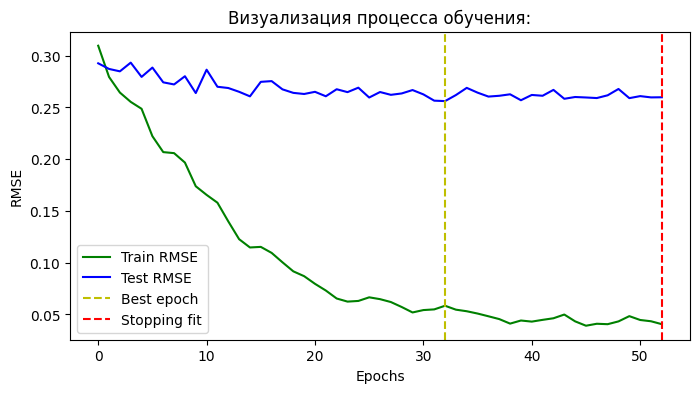

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(result['rmse_train'], color='green', label='Train RMSE')
plt.plot(result['rmse_test'], color='blue', label='Test RMSE')


plt.axvline(x=result['best_epoch'], color='y', linestyle='--', label='Best epoch')


plt.axvline(x=result['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(loc='lower left')
plt.show()

## Тестирование модели

In [53]:
test_images_list = test_df['image'].unique()

test_vektors = []

for image_name in tqdm(test_images_list):
    image = Image.open(os.path.join(TEST_IMAGES, image_name)).convert('RGB')
    image = preprocess(image)
    image = Variable(image.unsqueeze(0)).to(device)

    vektor = resnet(image).cpu().flatten().numpy() # преобразование в одномерный массив
    test_vektors.append(vektor)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.53it/s]


In [54]:
images_test_vektors = np.array(test_vektors)
test = pd.DataFrame({'image': test_images_list, 'image_vector': images_test_vektors.tolist()})

In [55]:
 # Замена нескольких пробелов одним и нежелательные символы
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(LETTERS, ' ', txt)  
    txt = re.sub(SPACES, r'\1', txt) 
    return txt

def stopwords_tokenize(x):
    tokens = word_tokenize(x)  # Токенизация текста
    tokenization = [word for word in tokens if word not in english_stopwords]
    return ' '.join(tokenization)

def clean_tokenize_text(text):
    text = clean_text(text)
    text = stopwords_tokenize(text)
    return text.split()

# Генерация текстового вектора
def get_text_embedding(input_text):
    tokenized = tokenizer.encode(input_text, max_length=512, truncation=True, add_special_tokens=True)
    padded = pad_sequence([torch.as_tensor(tokenized)], batch_first=True)
    attention_mask = padded > 0
    attention_mask = attention_mask.type(torch.LongTensor).to(device)

    with torch.no_grad():
        text_embedding = model_emb_txt(padded.to(device), attention_mask=attention_mask)[0][:, 0, :].cpu().numpy()
    return text_embedding[0].tolist()

# Функция тестирования
def imag_test(query_text):

    text_embedding = get_text_embedding(query_text)

    test['vector'] = test['image_vector'].apply(lambda x: text_embedding + x)
    test['vector'] = test['vector'].apply(lambda x: np.array(x, dtype=np.float32))

    test_vectors = np.stack(test['vector'].to_numpy())
    X_test_tensor = torch.tensor(test_vectors, dtype=torch.float32).to(device)

    # Предсказания модели
    with torch.no_grad():
        test['pred'] = best_regressor(X_test_tensor).detach().cpu().numpy()

    max_score = test['pred'].max()
    path = test[test['pred'] == max_score]['image'].values[0]
    return max_score, path

# Функция вывода изображения
def display_image_with_caption(query_text):
    text = clean_tokenize_text(query_text)

    # Проверка на запрещённые слова
    if any(i in text for i in child_dict):
        print(query_text)
        print('Изображение не доступно в данном регионе')
    else:
        max_score, image_path = imag_test(query_text)
        fig, ax = plt.subplots(figsize=(6, 6))
        image_path = os.path.join(TEST_IMAGES, image_path)
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(query_text, fontsize=12)
        ax.axis('off')
        plt.show()
        print(f'Мера соответствия изображения составляет: {max_score}')


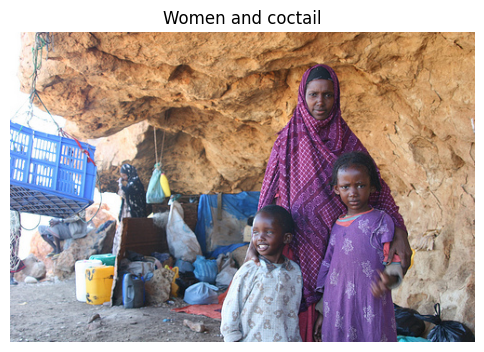

Мера соответствия изображения составляет: 0.6840725541114807


In [56]:
# from nltk.corpus import stopwords
# nltk.download('stopwords')

english_stopwords = stopwords.words('english')

display_image_with_caption('Women and coctail')

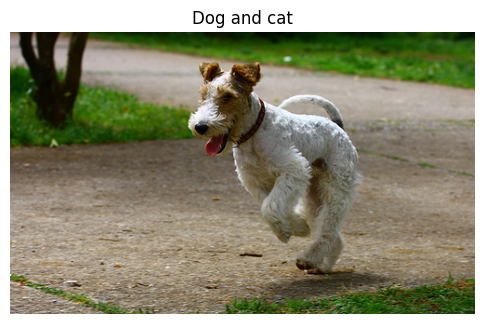

Мера соответствия изображения составляет: 0.8273761868476868


In [57]:
display_image_with_caption('Dog and cat')

In [58]:
display_image_with_caption('a child on a swing')

a child on a swing
Изображение не доступно в данном регионе


## Выводы


Код работает, детей фильтрует, а вот качество страдает. Нужно подобрать модель которая лучше будет работать с изображениями.